In [1]:
from utils import SimulationEnvironment
from basic_walk.utils import BaseAgent
import sys
import time


import pickle
import matplotlib.pyplot as plt
import numpy as np

from tqc import structures, DEVICE
from tqc.trainer import Trainer
from tqc.structures import Actor, Critic, RescaleAction
from tqc.functions import eval_policy
from tqdm import tqdm, trange
import copy

from IPython.display import clear_output

## Обучение нового агента

In [2]:
def draw_return(e_return, title="episodes_return"):
    plt.figure(figsize=(13, 9))
    plt.title(title)
    plt.xlabel("episode")
    plt.ylabel("reward")
    plt.plot(e_return)
    plt.show()

In [3]:
def prepare_main_classes(
    **kwarg
):
    actor = None
    trainer = None
    replay_buffer = kwarg["replay_buffer"]

    with SimulationEnvironment('scenes/basic_scene.ttt', headless_mode=True, foot_only_mode=True) as env:
        state_dim = env.observation_space.shape[0]
        action_dim = env.action_space.shape[0]
        print("state_dim", state_dim)
        print("action_dim", action_dim)
        if replay_buffer is None:
            replay_buffer = structures.ReplayBuffer(state_dim, action_dim)

        actor = Actor(state_dim, action_dim).to(DEVICE)
        critic = Critic(state_dim, action_dim, kwarg["n_quantiles"], kwarg["n_nets"]).to(DEVICE)
        critic_target = copy.deepcopy(critic)
        
        top_quantiles_to_drop = kwarg["top_quantiles_to_drop_per_net"] * kwarg["n_nets"]
        trainer = Trainer(actor=actor,
                          critic=critic,
                          critic_target=critic_target,
                          top_quantiles_to_drop=top_quantiles_to_drop,
                          discount=kwarg["discount"],
                          tau=kwarg["tau"],
                          target_entropy=-np.prod(env.action_space.shape).item()
         )
    
    return actor, trainer, replay_buffer

In [4]:
def pretrain(
    actor,
    trainer,
    replay_buffer,
    pretrain_iters,
    batch_size,
    episode_length,
    percantage_eval=0.02
):
    if replay_buffer is None or not replay_buffer.size:
        return actor, trainer
  
    evaluations = []  
    next_eval = 0
    
    actor.train()
    for t in trange(pretrain_iters):
        trainer.train(replay_buffer, batch_size)
        if float(t + 1) / pretrain_iters >= next_eval:
            next_eval += percantage_eval
            with SurrogatPyRepEnvironment('scenes/basic_scene.ttt', headless_mode=True, foot_only_mode=True) as env:
                env = RescaleAction(env, -1., 1.)
                avg_reward = eval_policy(actor, env, episode_length)
                evaluations.append(avg_reward)
                
            clear_output(True)
            draw_return(evaluations, "eval_reward")
    actor.eval()
    
    return actor, trainer

In [5]:
def fill_default_kwarg(kwarg):
    d_kwarg = dict(
        max_timesteps=1e6,
        seed=0,
        n_quantiles=25,
        top_quantiles_to_drop_per_net=2,
        n_nets=5,
        batch_size=256,
        discount=0.99,
        tau=0.005,
        episode_length=600,
        eval_freq=50000,
        save_model=True,
        replay_buffer=None,
        pretrain_iters=10000,
        draw_freq=500
    )
    d_kwarg.update(kwarg)
    return d_kwarg


def train(
    **kwarg
):
    kwarg = fill_default_kwarg(kwarg)
    
    actor, trainer, replay_buffer = prepare_main_classes(**kwarg)

    actor, trainer = pretrain(
        actor,
        trainer,
        replay_buffer,
        kwarg["pretrain_iters"],
        kwarg["batch_size"],
        kwarg["episode_length"],
    )

    actor.train()
    with SimulationEnvironment('scenes/basic_scene.ttt', headless_mode=True, foot_only_mode=True) as env:
        env = RescaleAction(env, -1., 1.)

        state, done = env.reset(), False
        episodes_return = [0]
        episode_timesteps = 0
        episode_num = 0   
        info = [[]]

        for t in trange(kwarg["max_timesteps"]):
            episode_timesteps += 1
            action = actor.select_action(state)
            next_state, reward, done, current_info = env.step(action)
            
            replay_buffer.add(state, action, next_state, reward, done)
            state = next_state
            episodes_return[-1] += reward
#             print(current_info)
            info[-1].append(current_info)
            
            if replay_buffer.size > kwarg["batch_size"]:
                trainer.train(replay_buffer, kwarg["batch_size"])
            
            if done or episode_timesteps >= kwarg["episode_length"]:
#                 print("Done!")
                if len(episodes_return) % kwarg["draw_freq"] == 0:
                    clear_output(True)
                    draw_return(episodes_return)
                if len(info[-1]) < 70:
                    info.pop(-1)
                state, done = env.reset(), False
                episodes_return.append(0)
                episode_timesteps = 0
                episode_num += 1
                info.append([])

            if (t + 1) % kwarg["eval_freq"] == 0:
                file_name = f"data/models/model_{t+1}"
                if kwarg["save_model"]:
                    trainer.save(file_name)
                file_name = f"data/learning_info/info_{t+1}.pickle"
                with open(file_name, 'wb') as f:
                    pickle.dump(info, f)
        return actor, info

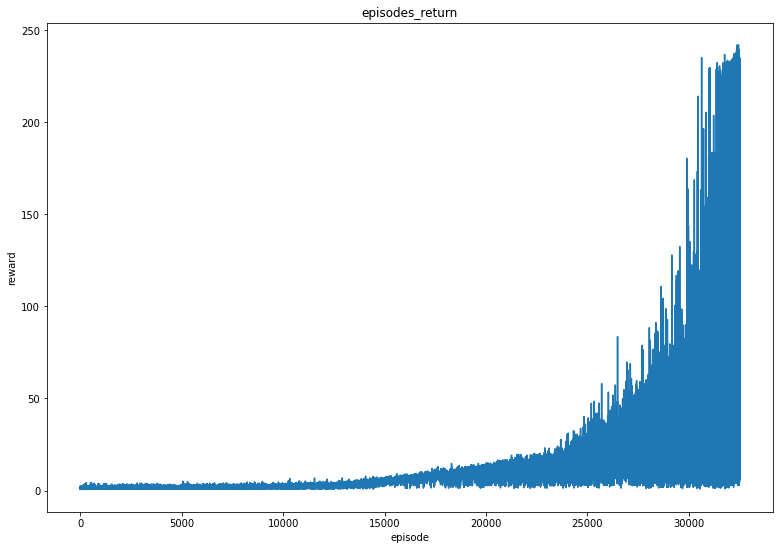

 19%|█▉        | 940660/5000000 [11:10:24<54:55:51, 20.53it/s] 

In [ ]:
replay_buffer = None
# with open('data/replay_buffers/replay_buffer_leg_only_200000_100.pickle', 'rb') as f:
#     replay_buffer = pickle.load(f)

    
# actor, info = train(
#     max_timesteps=1500,
#     seed=0,
#     n_quantiles=25,
#     top_quantiles_to_drop_per_net=2,
#     n_nets=5,
#     batch_size=256,
#     discount=0.99,
#     tau=0.005,
#     episode_length=500,
#     eval_freq=500,
#     save_model=True,
#     replay_buffer=replay_buffer
# )
actor, info = train(
    max_timesteps=5000000,
#     max_timesteps=10000,
    seed=0,
    n_quantiles=25,
    top_quantiles_to_drop_per_net=2,
    n_nets=5,
    batch_size=256,
    discount=0.99,
    tau=0.005,
    episode_length=500,
    eval_freq=100000,
    save_model=True,
    replay_buffer=replay_buffer,
    pretrain_iters=100000,
)

## Анализ обучения

In [ ]:
def extract_param(info_log, param_name):
    param = []
    for info in info_log:
        param.append(info[param_name])
    
    return param

In [ ]:
for i, cur_info in enumerate(info):
    if len(cur_info) < 500:
        continue
    reward = extract_param(cur_info, "reward")
    plt.title(i)
    plt.plot(reward)
    plt.show()

# Display Replay

In [ ]:
substr

In [ ]:
actions = extract_param(info[2], "action")
with SurrogatPyRepEnvironment('scenes/basic_scene.ttt', headless_mode=False) as env:
    env.reset()
    time.sleep(3)
    for action in actions:
        env.step(action)
        time.sleep(1)